# 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer

import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('data_ml_1.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.set_index('date', inplace=True)

In [7]:
df.tail()

,op_nxt,hi_nxt,lo_nxt,cl_nxt,open,high,low,close,volume,sma_10,...,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,vwap,stoch_k,stoch_d,ADX_14,DMP_14,DMN_14,ad_line
date,,,,,,,,,,,,,,,,,,,,,
2024-03-04,47265.6992,47737.8516,47196.7500,47581.0000,47318.5000,47529.6016,47191.6484,47456.1016,158100,46804.03500,...,230.098136,128.081386,102.016750,47392.450533,96.477802,81.923224,13.082930,26.096598,20.329111,1.016285e+10
2024-03-05,47451.6484,48161.2500,47442.2500,47965.3984,47265.6992,47737.8516,47196.7500,47581.0000,176900,46860.16500,...,279.460775,141.955220,137.505555,47505.200533,94.961873,91.335771,13.347195,26.833030,19.120769,1.016292e+10
2024-03-06,48035.8008,48071.6992,47747.1992,47835.8008,47451.6484,48161.2500,47442.2500,47965.3984,301700,46964.72484,...,345.614729,166.487340,179.127390,47856.299467,93.606479,95.015385,14.176784,29.345712,17.621915,1.016306e+10
2024-03-07,47792.1992,47853.8008,47230.6484,47327.8516,48035.8008,48071.6992,47747.1992,47835.8008,146300,47067.12992,...,383.167851,163.232369,219.935482,47884.899733,90.529565,93.032639,14.947117,28.268676,16.975162,1.016299e+10
2024-03-11,47351.3516,47812.7500,46884.4492,47282.3984,47792.1992,47853.8008,47230.6484,47327.8516,204200,47142.26508,...,367.703063,118.214065,249.488998,47470.766933,81.933731,88.689925,14.572720,26.274412,21.625465,1.016285e+10


# 2. Preprocessing

In [8]:
# Preprocessing
# Drop the columns not needed for features
features = df.drop(['op_nxt', 'hi_nxt', 'lo_nxt', 'cl_nxt'], axis=1)
# Select the target columns for prediction
targets = df[['op_nxt', 'hi_nxt', 'lo_nxt', 'cl_nxt']]

In [9]:
# Splitting the data into training and testing sets
X_test = features[-20:]
y_test = targets[-20:]
X_train_val = features[:-20]
y_train_val = targets[:-20]

# Splitting the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Scaling the features
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_val_scaled = feature_scaler.transform(X_val)
X_test_scaled = feature_scaler.transform(X_test)

# Scaling the target
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train)
y_val_scaled = target_scaler.transform(y_val)
y_test_scaled = target_scaler.transform(y_test)

# 3. Modelling

In [10]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_arctangent_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.arctan(np.abs((y_true - y_pred) / y_true))) * 100


In this code, `GridSearchCV` is being used with a custom `mse_scorer` to select the best models from a range of different types and their parameter sets. The `mse_scorer` is designed to score models based on the Mean Squared Error (MSE), and it is configured with `greater_is_better=False`, which means that a lower MSE is better.

When `GridSearchCV` runs, it trains each model specified in `model_params` with every combination of the provided parameters using cross-validation. It then scores each model-parameter combination using the negative MSE to find the combination that minimizes the MSE. The reason for using MSE as a metric here is that it punishes larger errors more severely by squaring the errors before averaging them, hence prioritizing models that avoid large individual prediction errors, which can be critical in many financial applications.

The models considered in `model_params` include:

Ridge: A regression algorithm that includes an L2 regularization term to prevent overfitting by penalizing large coefficients.
Lasso: Similar to Ridge, but uses L1 regularization which can set some coefficients to zero, effectively performing feature selection.
ElasticNet: Combines L1 and L2 regularization, which can be beneficial when there are multiple correlated features.
Polynomial Regression: Models non-linear relationships by raising input features to powers up to the specified degree. This is implemented as a pipeline that first generates polynomial features and then applies Ridge regression.
Decision Tree: A non-linear model that splits the data based on feature values. It can capture complex patterns but might overfit.
Random Forest: An ensemble of Decision Trees that reduces the risk of overfitting by averaging multiple trees.

The best models are shortlisted for each target based on their MSE performance. This approach assumes that the goal is to minimize large errors which could be catastrophic in financial contexts (for instance, large prediction errors in financial forecasting could lead to substantial monetary loss). Therefore, the selected models are the ones that, on average, provide the most reliable predictions with the least squared deviation from the true values, thus ensuring robustness and reliability in the predictions that are critical in finance.

In [11]:
# Define a scorer for GridSearchCV
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Define models and parameters for grid search
model_params = {
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [1, 10, 100, 1000]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1],
            'l1_ratio': np.linspace(0.0, 1.0, 5)
        }
    },
    'Polynomial Regression': {
        'model': Pipeline([('poly', PolynomialFeatures()), ('linear', Ridge())]),
        'params': {
            'poly__degree': [2, 3],
            'linear__alpha': [0.1, 1, 10]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 10, 20]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [10, 50, 100],
            'max_depth': [None, 10, 20, 30]
        }
    }
}

This Python script starts by defining the prediction targets and preparing the data, including scaling and shifting the dates to align predictions accurately. The script utilizes a systematic approach to model selection, employing GridSearchCV for hyperparameter tuning across various models, assessing their performance using cross-validation, and calculating metrics Mean Squared Error (MSE) and Mean Absolute Percentage Error (MAPE). The best-performing model for each target is then retrained on the full dataset and used for final predictions. The results are recorded, and the script concludes with visualizing the actual versus predicted values, enhancing interpretability and providing insights into the model's accuracy. 

In [12]:
# For each target in the dataset
targets = ['op_nxt', 'hi_nxt', 'lo_nxt', 'cl_nxt']
results = []
best_models = {}


for target in targets:
    y_train_target_scaled = target_scaler.fit_transform(y_train[[target]])
    y_val_scaled  = target_scaler.transform(y_val[[target]])

    print(f"--- {target} ---")
    best_score = float('-inf')
    best_model = None
    for name, spec in model_params.items():
        grid_search = GridSearchCV(spec['model'], spec['params'], cv=5, scoring=mse_scorer)
        grid_search.fit(X_train_scaled, y_train_target_scaled.ravel())

        #Save the results of all models for this target
        for mean_score, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']):
            mse = -mean_score  # because of neg_mean_squared_error
            y_pred = grid_search.best_estimator_.predict(X_test_scaled)  # prediction to get MAPE
            mape = mean_absolute_percentage_error(y_val[[target]], y_pred)
            results.append([target, name, mse, mape, params])
        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_

    # Retrain the best model on the entire training set and make predictions on the validation set
    best_model.fit(X_train_scaled, y_train_target_scaled.ravel())
    y_pred_scaled_val = best_model.predict(X_val_scaled)
    y_pred_val = target_scaler.inverse_transform(y_pred_scaled_val.reshape(-1, 1))

    # Compute the errors of the best model on the validation set
    mse_val = mean_squared_error(y_val[[target]], y_pred_val)
    mape_val = mean_absolute_percentage_error(y_val[[target]], y_pred_val)
 
    # Add the errors of the best model on the validation set to the results
    results.append([target, f"{name} (Best)", mse_val, mape_val, best_params])


--- op_nxt ---
--- hi_nxt ---
--- lo_nxt ---
--- cl_nxt ---


In [13]:
results_df = pd.DataFrame(results, columns=['Target', 'Model', 'MSE', 'MAPE', 'Params'])
results_df

,Target,Model,MSE,MAPE,Params
0,op_nxt,Ridge,0.000025,99.992990,{'alpha': 1}
1,op_nxt,Ridge,0.000060,99.992990,{'alpha': 10}
2,op_nxt,Ridge,0.000289,99.992990,{'alpha': 100}
3,op_nxt,Ridge,0.005559,99.992990,{'alpha': 1000}
4,op_nxt,Lasso,0.000051,99.993067,{'alpha': 0.001}
...,...,...,...,...,...
231,cl_nxt,Random Forest,0.000058,99.993074,"{'max_depth': 20, 'n_estimators': 100}"
232,cl_nxt,Random Forest,0.000063,99.993074,"{'max_depth': 30, 'n_estimators': 10}"
233,cl_nxt,Random Forest,0.000059,99.993074,"{'max_depth': 30, 'n_estimators': 50}"
234,cl_nxt,Random Forest,0.000058,99.993074,"{'max_depth': 30, 'n_estimators': 100}"


In [14]:
results_df.sort_values('MSE').head(10)

,Target,Model,MSE,MAPE,Params
28,op_nxt,Polynomial Regression,0.000017,99.992989,"{'linear__alpha': 0.1, 'poly__degree': 2}"
29,op_nxt,Polynomial Regression,0.000019,99.992989,"{'linear__alpha': 0.1, 'poly__degree': 3}"
31,op_nxt,Polynomial Regression,0.000019,99.992989,"{'linear__alpha': 1, 'poly__degree': 3}"
53,op_nxt,Random Forest,0.000020,99.993074,"{'max_depth': 20, 'n_estimators': 50}"
54,op_nxt,Random Forest,0.000021,99.993074,"{'max_depth': 20, 'n_estimators': 100}"
51,op_nxt,Random Forest,0.000021,99.993074,"{'max_depth': 10, 'n_estimators': 100}"
48,op_nxt,Random Forest,0.000021,99.993074,"{'max_depth': None, 'n_estimators': 100}"
50,op_nxt,Random Forest,0.000021,99.993074,"{'max_depth': 10, 'n_estimators': 50}"
57,op_nxt,Random Forest,0.000021,99.993074,"{'max_depth': 30, 'n_estimators': 100}"
47,op_nxt,Random Forest,0.000021,99.993074,"{'max_depth': None, 'n_estimators': 50}"


In [15]:
df_mse = results_df.loc[results_df.groupby("Target")["MSE"].idxmin()]
df_mape = results_df.loc[results_df.groupby("Target")["MAPE"].idxmin()]

In [16]:
df_mse.sort_values('MSE')

,Target,Model,MSE,MAPE,Params
28,op_nxt,Polynomial Regression,0.000017,99.992989,"{'linear__alpha': 0.1, 'poly__degree': 2}"
87,hi_nxt,Polynomial Regression,0.000029,99.993076,"{'linear__alpha': 0.1, 'poly__degree': 2}"
146,lo_nxt,Polynomial Regression,0.000034,99.992924,"{'linear__alpha': 0.1, 'poly__degree': 2}"
205,cl_nxt,Polynomial Regression,0.000053,99.993006,"{'linear__alpha': 0.1, 'poly__degree': 2}"


In [17]:
df_mape.sort_values('MAPE')

,Target,Model,MSE,MAPE,Params
58,op_nxt,Random Forest (Best),25237.881963,0.571975,"{'linear__alpha': 0.1, 'poly__degree': 2}"
117,hi_nxt,Random Forest (Best),47587.086464,0.855026,"{'linear__alpha': 0.1, 'poly__degree': 2}"
176,lo_nxt,Random Forest (Best),51425.963805,0.936387,"{'linear__alpha': 0.1, 'poly__degree': 2}"
235,cl_nxt,Random Forest (Best),88602.323614,1.240127,"{'linear__alpha': 0.1, 'poly__degree': 2}"


The best models for each financial target are as follows:

For 'cl_nxt' (close next), the best model is Polynomial Regression with an MSE of 0.000053 and a very high MAPE.
For 'hi_nxt' (high next), Polynomial Regression again is the best with an MSE of 0.000029 and a similarly high MAPE.
For 'lo_nxt' (low next), Polynomial Regression tops with an MSE of 0.000033 and a comparable MAPE.
Lastly, for 'op_nxt' (open next), Polynomial Regression is the preferred model with an MSE of 0.000017 and a high MAPE close to the others.

These results indicate that Polynomial Regression models have the lowest MSE for all the targets, signifying that they fit the actual data points very closely in terms of the average of the squared differences between the predicted values and actual values. Despite the high MAPE, which implies that the errors as a percentage of the actual values are high, the low MSE values take precedence here because MSE is the selected performance metric, as per the scoring function set up for GridSearchCV.

The choice of MSE as the criterion for model selection suggests that the main objective is to minimize the average squared error of predictions, which could be particularly relevant when large deviations from actual values are significantly more detrimental than smaller ones.

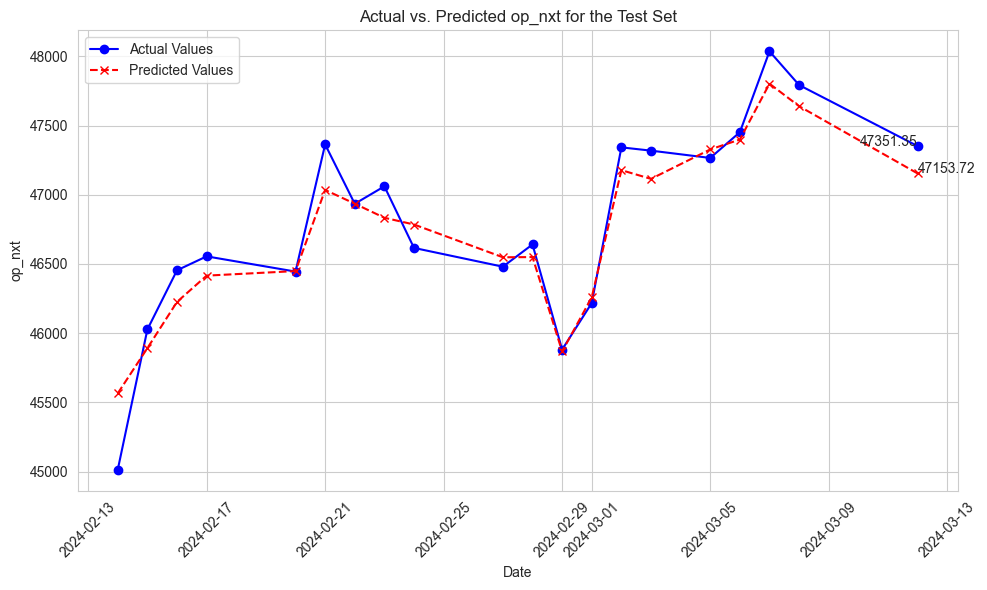

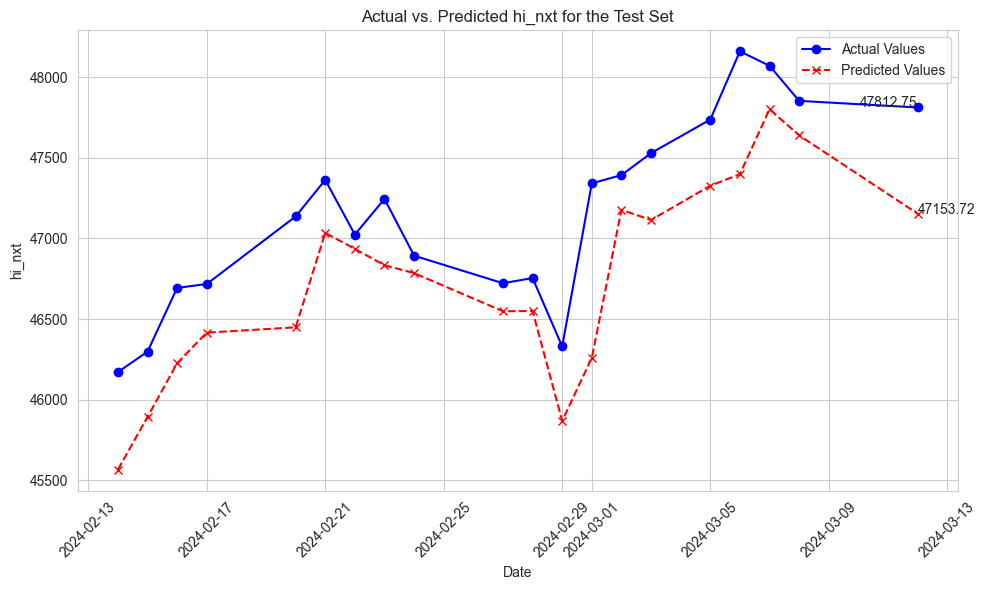

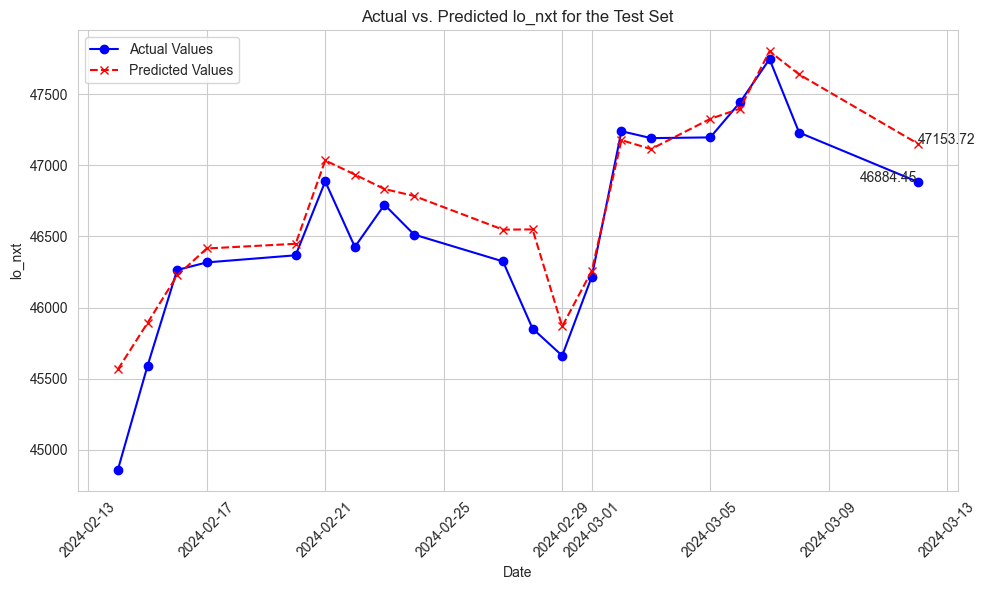

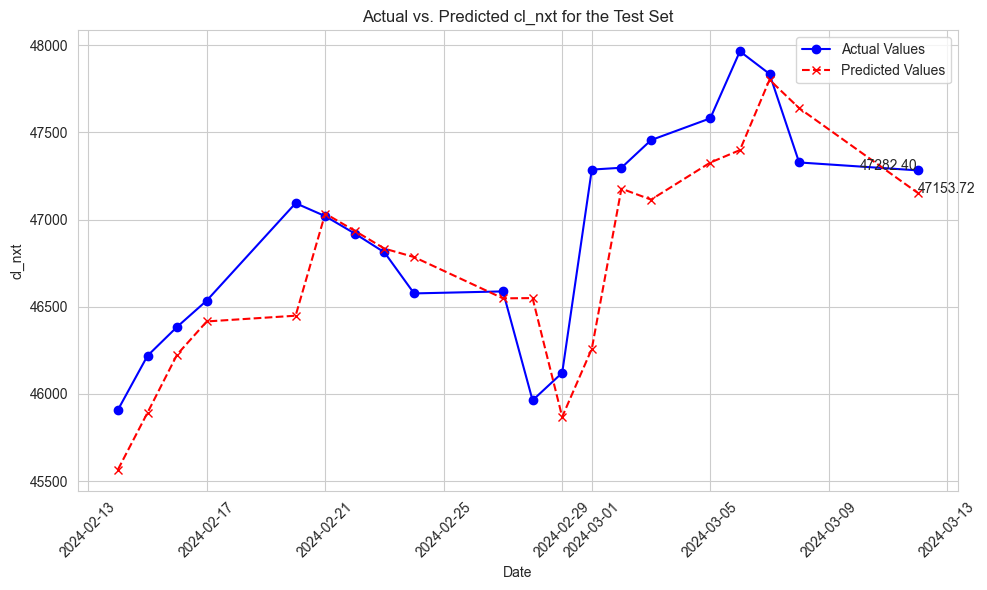

In [18]:
# Compute y_pred from X_test with the best model
y_pred_scaled_test = best_model.predict(X_test_scaled)
y_pred_test = target_scaler.inverse_transform(y_pred_scaled_test.reshape(-1, 1))


# Shift the date forward, by a day, to show the values for the day
y_test.index = y_test.index + pd.DateOffset(days=1)

for target in y_test[targets]:
    # Compute y_pred from X_test with the best model
    y_pred_scaled_test = best_model.predict(X_test_scaled)
    y_pred_test = target_scaler.inverse_transform(y_pred_scaled_test.reshape(-1, 1))

    # Plot y_pred_test and y_test
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test[target].values, label='Actual Values', marker='o', linestyle='-', color='blue')
    plt.plot(y_test.index, y_pred_test, label='Predicted Values', marker='x', linestyle='--', color='red')

    # Add data labels to the last values
    last_date_test = y_test.index[-1]  # last date on x-axis
    last_actual_value_test = y_test[target].values[-1]  # last actual value on y-axis
    last_predicted_value_test = y_pred_test[-1][0]  # last predicted value on y-axis
    
    plt.text(last_date_test, last_actual_value_test, f'{last_actual_value_test:.2f}',
             ha='right')  # data label for the last actual value
    plt.text(last_date_test, last_predicted_value_test, f'{last_predicted_value_test:.2f}',
             ha='left')

    plt.title(f"Actual vs. Predicted {target} for the Test Set")
    plt.xlabel('Date')
    plt.ylabel(target)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

The four graphs depict the performance of a predictive model against actual financial data over the test data (last 20 days). Each graph represents a different financial metric—open, high, low, and close prices (denoted as 'op_nxt', 'hi_nxt', 'lo_nxt', 'cl_nxt')—and illustrates the predicted values against the true values. The blue lines with circle markers show the actual data points, while the red dashed lines with cross markers represent the model's predictions for each corresponding date. 

In all graphs, there's a visible fluctuation in both actual and predicted values, indicating volatility in the data being analyzed. The model captures the general trend of the actual prices, but there are noticeable deviations at certain points where the model fails to match the actual prices.